In [16]:
import os
import numpy as np
import h5py
import sys

# a=np.array([[1,2],[3,4],[5,6]], dtype=float)
# print a
# m=a.mean(axis=0)
# print m
# a-=m
# print a
# v='Y'
# vv=1 if 'N'==v else 0
# print vv
m='2018-10'
mm=m.split('-')
_m=(2019-int(mm[0]))*12+2-int(mm[1])
print _m

print ord('B')-ord('A')

def print_example(dict,c):
    i=0
    for k,v in dict.items():
        if i>c:
            break
        print (k,v)
        i+=1
def process_transaction(dict,transaction,length):
    card_id=transaction[1]
    if not card_id in dict:
        dict[card_id]=np.zeros(length,dtype=float)
    # quantity of transactions
    dict[card_id][0]+=1
    # total purchase price amount
    dict[card_id][1]+=float(transaction[9])
    # earliset months month lag
    lag=int(transaction[8])
    dict[card_id][2]=lag if lag<dict[card_id][2] else dict[card_id][2]
    # quantity of approved transactions
    dict[card_id][3]+=1 if 'Y'==transaction[0] else 0
    #feature_1
    dict[card_id][4]=0
    #feature_2
    dict[card_id][5]=0
    #feature_3
    dict[card_id][6]=0
    #active month
    dict[card_id][7]=0
#     #category_1 (Y, N)
#     dict[card_id][7]+=1 if 'Y'==transaction[3] else 0
#     #category_2 ('',1,2,3,4,5)
#     c2=transaction[11]
#     dict[card_id][8]=c2 if c2 else 0
#     #category_3 ('',A,B,C)
#     c3=transaction[5]
#     dict[card_id][9]=ord(c3)-ord('A') if c3 else -1
def process_train(dict,line):
    card_id=line[1]
    #feature_1
    dict[card_id][4]=line[2]
    #feature_2
    dict[card_id][5]=line[3]
    #feature_3
    dict[card_id][6]=line[4]
    #active month
    m=line[0].split('-')
    dict[card_id][7]=(2019-int(m[0]))*12+2-int(m[1])

4
1


In [9]:
data_dir='/home/lei/ML/Data/Kaggle/elo-merchant-category-recommendation'
data_file=os.path.join(data_dir,'train.h5')
features=8

if not os.path.exists(data_file):
    cards,target_index,test_index={},{},{}
    f=open(os.path.join(data_dir,'new_merchant_transactions.csv'))
    next(f)
    for line in f:
        values=line.split(',')
        process_transaction(cards,values,features)
    f.close()
    f=open(os.path.join(data_dir,'historical_transactions.csv'))
    next(f)
    for line in f:
        values=line.split(',')
        process_transaction(cards,values,features)
    f.close()
    count=len(cards)
    train_size=0
    f=open(os.path.join(data_dir,'train.csv'))
    next(f)
    for line in f:
        values=line.split(',')
        target_index[values[1]]=values[5]
        process_train(cards,values)
        train_size+=1
    f.close()
    f=open(os.path.join(data_dir,'test.csv'))
    next(f)
    for line in f:
        values=line.split(',')
        process_train(cards,values)
    f.close()
    print sys.getsizeof(cards)
    
    train=np.zeros((train_size,features),dtype=float)
    target=np.zeros(train_size,dtype=float)
    test=np.zeros((count-train_size,features),dtype=float)
    i,j=0,0
    for k,v in cards.items():
        if k in target_index:
            train[i]=v
            target[i]=target_index[k]
            i+=1
        else:
            test[j]=v
            test_index[k]=j
            j+=1
    print train.shape,target.shape,test.shape,len(test_index)
    
    mean=train.mean(axis=0)
    print mean
    train-=mean
    std=train.std(axis=0)
    print std
    train/=std
    test-=mean
    test/=std
    ind = np.array([[k,v] for k,v in test_index.items()])
    print ind.shape
    h5f = h5py.File(data_file,'w')
    h5f.create_dataset('train',data=train)
    h5f.create_dataset('target',data=target)
    h5f.create_dataset('test',data=test)
    h5f.create_dataset('test_index',data=ind)
    h5f.close()
else:
    print 'file exist'

12583192
(201917, 7) (201917,) (123623, 7) 123623
[95.33468702 11.0902082  -7.87777651 87.59950871  3.1053106   1.74541024
  0.56556902]
[1.06910557e+02 1.34491274e+04 3.84330370e+00 1.01631439e+02
 1.18615665e+00 7.51359876e-01 4.95682059e-01]
(123623, 2)


In [10]:
h5f=h5py.File(data_file,'r')
_train=h5f['train'][:]
_target=h5f['target'][:]
_test=h5f['test'][:]
index=h5f['test_index'][:]
h5f.close()

test_index={}
for item in index:
    test_index[item[0]]=int(item[1])
print _train.shape,_target.shape,_test.shape,len(test_index)

(201917, 7) (201917,) (123623, 7) 123623


In [11]:
import keras
from keras import models
from keras import layers
keras.__version__
def build_model():
    model=models.Sequential()
    model.add(layers.Dense(128,activation='relu',input_shape=(_train.shape[1],)))
    model.add(layers.Dense(128,activation='relu'))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
    return model

num_epochs=15
train_data=_train[:151917]
train_target=_target[:151917]
val_data=_train[151918:]
val_target=_target[151918:]
# test_data=_train[151918:]
# test_target=_target[151918:]
model=build_model()
# Train the model (in silent mode, verbose=0)
history=model.fit(train_data, train_target,validation_data=(val_data,val_target),epochs=num_epochs, batch_size=10)
# test_mse_score,test_mae_score = model.evaluate(test_data, test_target)
# print test_mse_score,test_mae_score

Train on 151917 samples, validate on 49999 samples
Epoch 1/15
151917/151917 [==============================] - 11s 73us/step - loss: 15.0125 - mean_absolute_error: 1.5755 - val_loss: 14.5748 - val_mean_absolute_error: 1.5922
Epoch 2/15
151917/151917 [==============================] - 11s 73us/step - loss: 14.9591 - mean_absolute_error: 1.5861 - val_loss: 14.5978 - val_mean_absolute_error: 1.6360
Epoch 3/15
151917/151917 [==============================] - 11s 74us/step - loss: 14.9125 - mean_absolute_error: 1.5983 - val_loss: 14.6146 - val_mean_absolute_error: 1.5761
Epoch 4/15
151917/151917 [==============================] - 11s 72us/step - loss: 14.9644 - mean_absolute_error: 1.6048 - val_loss: 14.7291 - val_mean_absolute_error: 1.5709
Epoch 5/15
151917/151917 [==============================] - 11s 74us/step - loss: 15.0051 - mean_absolute_error: 1.6077 - val_loss: 14.6209 - val_mean_absolute_error: 1.5555
Epoch 6/15
151917/151917 [==============================] - 11s 72us/step - los

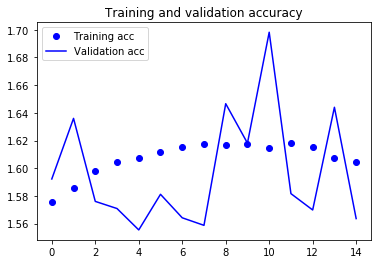

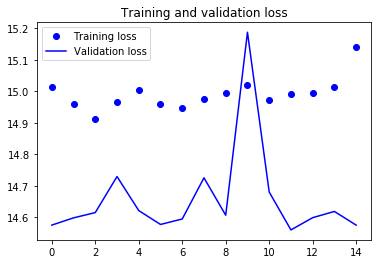

In [12]:
import matplotlib.pyplot as plt
val_acc = history.history['val_mean_absolute_error']
acc = history.history['mean_absolute_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
pred_file=os.path.join(data_dir,'pred.csv')
input_data=np.zeros(_test.shape,dtype=float)
f=open(os.path.join(data_dir,'test.csv'))
next(f)
i=0
id=[]
for line in f:
    values=line.split(',')
    input_data[i]=_test[test_index[values[1]]]
    id.append(values[1])
    i+=1
f.close()
pred=model.predict(input_data)
out=open(pred_file,'w')
out.write('card_id,target\n')
for i in range(len(pred)):
    out.write(id[i]+','+str(pred[i])[1:-1]+'\n')
    i+=1
out.close()